In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import PandasTools

from scipy import stats
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from utils import get_statisicts
from utils import pearson_confidence
from utils import max_possible_correlation
from utils import cluster_fps
from utils import get_data
from utils import get_sim_data

import pandas as pd

sns.set()

_(BE AWARE OF TYPOS)_

Below, there are some of the simulation results, analyses, and my comments regarding the models' performance and future directions. 

## Model trainig, cross-validation, and evaluations

Model descriptions (brief):      
1. `ESOLCalculator`: [Multivariate regression model](https://en.wikipedia.org/wiki/General_linear_model) based on the [ESOL model](https://pubs.acs.org/doi/10.1021/ci034243x).   
2. `RFRegressor`: [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) trained on 1024 bits of [ECFP](https://pubs.acs.org/doi/10.1021/ci100050t)4 and implemented with [scikit-learn](https://scikit-learn.org/stable/).  
3. `NfpRegressor`: Convolutional neural network trained on the [molecular graphs](https://github.com/HIPS/neural-fingerprint).
4. `EnsembleRegressor`: [Keras](https://keras.io/) implementation of one dense layer neural network with 28 (3+25) features. Three features are predictions from the above methods (fitted on the same cross-fold), and the remaining 25 features are [RDKit](https://www.rdkit.org/) physical properties. The idea is that since the methods are not perfectly correlated (Pearson's $R=1$), combining them gives more robust predictions. (12/28/19) This model is in a sense similar to the [StackingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html) (and [Pat's code](https://github.com/PatWalters/stacking_regressors/blob/master/stacking_regressors.py)). In our case we are "stacking" two linear models (ESOL and MLR with 25 features), RF and NFP.



Each model is trained and validated using 5 cross-fold validation. During the cross-validation, mean square error (mse) and Preason's $R^2$ were calculated.
No hyperparameters optimization were done, thus, in principle, validation sets (and the performance calculated for them) can be taken as a general performance on the Test Sets. The fallacy of this assumption/procedure will be discussed in the second section.           

The training set consists of 1865 datapoints for `solubility.uniq.no-in-100.smi` (or 1912 for `solubility.uniq.no-in-32.smi`) compounds with measured $\rm{log}S_0$. Each of this two datasets contain unique compounds, and all the compounds from Test Set 1 (TS-1) and Test Set 2 (TS-2) are exluded from the training set.  

The results below are for 4 models: ESOL, Random Forest (RF), Neural Fingerprint (Nfp), and Ensemble methods. 
For comparision, I also added data from the [putatively](https://github.com/pgniewko/solubility/blob/master/src/notebooks/assets/mpnn.moleculenet.png) best model (MPNN) that I found at the [MoleculeNet website](http://moleculenet.ai/). Because error bars were not provided, for plotting purposes, I set them to 0.

ESOLCalculator:	 0.7493291399122787 0.7861647391624803
EnsembleRegressor:	 0.8155966977018461 0.8436782454942452
MPNN:	 0.9334064465659521 0.9441377386957225
NfpRegressor:	 0.7312951337580055 0.7703773611852874
RFRegressor:	 0.659391213102679 0.7068128045156173


Text(0, 0.5, "Theoretical max. value of Pearson's R**2")

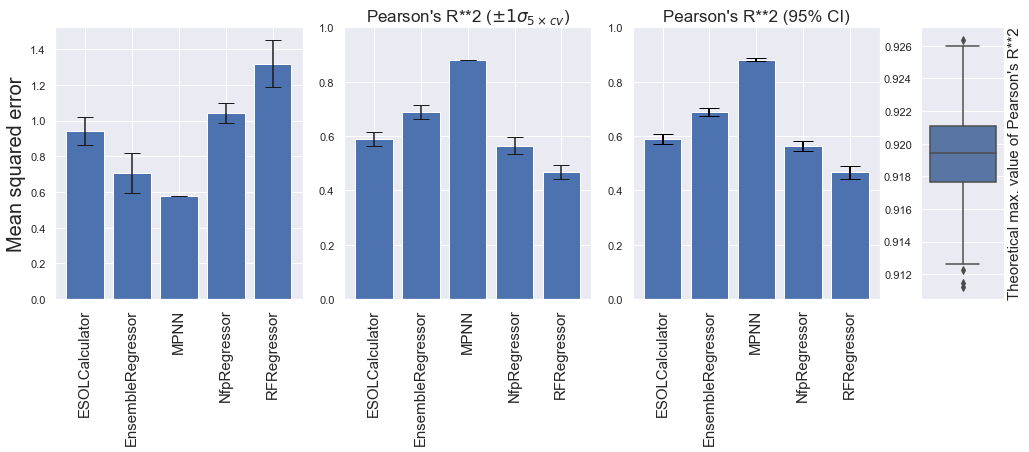

In [2]:
#The code below reads the data saved at the end of the trainig and validation, analyses and plots the results.

CURRENT_PATH = os.getcwd()
RESULTS_PATH = '{}/../../results'.format(CURRENT_PATH)

models_data_files = ['esol-no-in-100.dat',
                     'rf-no-in-100.dat',
                     'nfp-no-in-100.dat',
                     'ensemble-no-in-100.dat',
                     'mpnn.delaney.dat']

statistics_map = {'mse':0, 'mae':1, 'pearsonr':2}


# Read logS0 values used for training and cross-validation
logS0 = []
logS0_FILE = '{}/../../data/training/solubility.uniq.no-in-100.smi'.format(CURRENT_PATH)
with open(logS0_FILE, 'r') as fin:
    for line in fin:
        pairs = line.rstrip('\n').split(',')
        logS0.append(float(pairs[1]))

num = len(logS0)

fig = plt.figure(figsize=(17,5))
spec = fig.add_gridspec(ncols=4, nrows=1, width_ratios=[3,3,3,1])
ax1 = fig.add_subplot(spec[0,0])
ax2 = fig.add_subplot(spec[0,1])
ax3 = fig.add_subplot(spec[0,2])
ax4 = fig.add_subplot(spec[0,3])
ax2.set_ylim([0,1])
ax3.set_ylim([0,1])

# Mean square error
models_mse = get_statisicts('mse', models_data_files, statistics_map, RESULTS_PATH)
vals = [models_mse[key][0] for key in sorted(models_mse.keys())]
std = [models_mse[key][1] for key in sorted(models_mse.keys())]
ax1.bar(sorted(models_mse.keys()), vals, yerr=std,capsize=8)
ax1.set_xticklabels(sorted(models_mse.keys()), rotation=90, fontsize=15)
ax1.set_ylabel('Mean squared error', fontsize=20)

# Pearson's R
models_pearsonr = get_statisicts('pearsonr', models_data_files, statistics_map, RESULTS_PATH)
vals = [models_pearsonr[key][0]**2.0 for key in sorted(models_pearsonr.keys())]
std = [models_pearsonr[key][1] for key in sorted(models_pearsonr.keys())]
ax2.bar(sorted(models_pearsonr.keys()), vals, yerr=std,capsize=8)
ax2.set_xticklabels(sorted(models_pearsonr.keys()), rotation=90, fontsize=15)
ax2.set_title('Pearson\'s R**2 ($\pm 1\sigma_{5\\times cv}$)', fontsize=17)

# Confidence intervals
lb = []
ub = []
for model in sorted(models_pearsonr.keys()):
    values = models_pearsonr[model]
    r = values[0]**0.5 # R^2 --> R
    rlower, rupper = pearson_confidence(r, num, interval=0.95)
    lb.append(r**2 - rlower**2) # In respect to R^2
    ub.append(rupper**2 - r**2) # In respect to R^2
    print("{}:\t {} {}".format(model, rlower**2, rupper**2))
    
ax3.bar(sorted(models_pearsonr.keys()), vals, yerr=None)
ax3.errorbar(sorted(models_pearsonr.keys()), vals, yerr=[lb,ub], fmt="none", capsize=10, elinewidth=2,color='black')
ax3.set_xticklabels(sorted(models_pearsonr.keys()), rotation=90, fontsize=15)
ax3.set_title('Pearson\'s R**2 (95% CI)', fontsize=17)

ax4.yaxis.set_label_position("right")
_, pr_corrs =  max_possible_correlation(logS0, error=0.6, cycles=500)
sns.boxplot(np.array(pr_corrs)**2.0, ax=ax4, orient='v')
ax4.set_ylabel('Theoretical max. value of Pearson\'s R**2', fontsize=15)

The first plot from the left provides average MSE values (and standard deviations calculated over 5 cross-folds). Among 4 trained models, `EnsembleRegressor` is the best one, but it's outperformed by the `MPNN` model. Surprisingly, the perfomance of `MPNN` is below $MSE \approx 0.6 \rm{log}~units$, which raises some concerns in the context of putative experimental accuracy being about [`0.62`](https://pubs.acs.org/doi/10.1021/acs.jcim.9b00345) log units. When we look at the Pearson's $R^2$ coefficient, we can still see that `EnsembleRegressor` performs best. 95% confidence intervals are estimated [analytically](https://github.com/pgniewko/solubility/blob/master/src/notebooks/utils.py). Error bars between `EnsembleRegressor` don't overlap with the others; thus, at this confidence level we can say the `Ensemble` method is performing [better](https://www.ncbi.nlm.nih.gov/pubmed/26942422) than the other methods (except `MPNN`). However, all these four methods are outperformed by `MPNN`, with Pearson's $R^2$ reported to be 0.939. I checked the maximum possible Pearson's $\left<R^2\right>$ (as suggested [here](https://practicalcheminformatics.blogspot.com/2019/07/how-good-could-should-my-models-be.html)), with the assumption that the standard error is $0.6 \rm{log}~units$ (following this [paper](https://pubs.acs.org/doi/10.1021/acs.jcim.9b00345)). This calculation suggests that the theoretical maximal value of $R^2$ is in the range of $\approx[0.912, 0.928]$ (the 95% CI ). We can see that `MPNN` is not only reaching, but even exceeding, theoretical performance. In defense of `MPNN`, I will mention that the model was trained and evaluated on the original Delaney dataset (about 1200 compounds), which, by the way, makes up the majority of the training data in this work.

### Some comments on correlations between methods

The predictions from the algorithms discussed above are likely correlated. When the 95% CIs intervals overlap, or the statistics difference is smaller than the error bars, we cannot definitely conclude the difference (or equivalence) of two methods (except in the case where one error bar is enclosed by another, [Nicholls, A. 2016](https://www.ncbi.nlm.nih.gov/pubmed/26942422)). In such a case, pair-wise correlation coefficients are required. For our case, since the methods are studied on the same dataset, this is easily feasible. Otherwise, the correlation coefficient for two methods $X$ and $Y$ can be [estimated](https://www.ncbi.nlm.nih.gov/pubmed/26942422) based on their correlation coefficients with the target dataset, $R_X$ and $R_Y$, as $R_{XY} \approx R_XR_Y$. This approximation assumes that the source of the noise in each of the models is independent - which may not be true if models differ only slighlty and are based on the same physical principles. If so, the direct evaluation of the Pearson's $R$ (if no other prior knowledge is available) is necessary to properly estimate CIs for the difference between X and Y. 

### _y-randomization_ of the training dataset

With ESOL we have a small number (4) of features and we want to test to what extent the correlation between features can be used to predict randomized response variables (i.e. $\rm log S_0$), a procedure called [y-Randomization](https://pubs.acs.org/doi/abs/10.1021/ci700157b). The idea behind y-randomization is to break the relation between the features (descriptors) and related values. This procedure is especially valuable as a baseline to judge multilinear regression models with features selection (to get the best fit to the given data). In this project, we do not select features that best fit the data, so this calculation gives us only an idea about the error that we would expect in case of the broken relation between the features and target values. Not surprisingly, the correlation between the input and the output data is negligible (Pearson's $R\approx 0$). 95% CIs are approximated by the $2\sigma$ intervals assuming the errors have a symmetric distribution (calculated over 5 cross-folds). This assumption is likely violated for $R^2\approx 0$, but because the differences between the models and the baseline are much larger than $2\sigma$, the conclusions should stay the same upon the application of asymmetric correction. In short, the results in the table below show that the trained model significanly improve over predictions on the randomized data.

|Method| MSE ($\pm2\sigma$)  | MAE ($\pm2\sigma$)| Pearson's $R^2$ ($\pm2\sigma$)|        
|------|------------|------------|------------|   
|ESOL| 4.069 ($\pm$0.406) | 1.573 ($\pm$0.078) |  0.010($\pm$0.012) |      
|RF| 4.563 ($\pm$0.858) | 1.667 ($\pm$0.160) |  0.001 ($\pm$0.002) |    
|Nfp| 4.136 ($\pm$0.454) | 1.585 ($\pm$0.086) |  0.005 ($\pm$0.003) |   
|Ensemble|  4.878 ($\pm$0.512) | 1.737 ($\pm$0.072) |  0.006 ($\pm$0.012) |   

Table: Values for the "mode 2" y-randomization (refer to [paper](https://pubs.acs.org/doi/abs/10.1021/ci700157b) for more details). Target variables randomly permutated (shuffled). All descriptors/features are kept in order to build the model. MSE - mean squared error; MAE - mean absolute error.

# Models evaluation on Test Set1 and Test Set 2

The full data for Test Set 1 and 2 is not available at the moment (as of 12/01/2019), but some of the compounds in the test sets have their $\rm{log}S_0$ values known. These compounds are excluded from the training set and were used in a realistic but only partial evaluation of the trained models. For the analysis below, I trained 5 models based on 5 random cross-folds of the training set. Then, the final prediction of the $\rm logS_0$ is taken as an average over these 5 different models (cross-folds).        

Below, I provide data for the partial performance of these models. Ensemble regressor is best on TS-1, but interestingly its performance drops for TS-2. Random Forest model shows similar behavior! Interestingly, the most robust model seems to be the physics-based one: `ESOLCalculator`.

|Method| TEST SET 1 (100 compounds) | TEST SET 2 (32 compounds) |   
|------|------------|------------|
|ESOL| 0.878 | 1.072 |
|RF| 0.877 | 1.921 |
|Nfp| 1.348 | 2.632 |
|Ensemble| 0.738 | 1.447 | 
|GSE*| 0.826 | 1.144 |
|GSE (total) | 1.12 | 1.19 |

Table: 60 compounds have measured $\rm{log}S_0$ in Test Set 1, and 13 compounds have measured $\rm{log}S_0$ in Test Set 2. GSE* is RMSE for the subset of this two datasets (60 and 13 respectively), and GSE (total) is RMSE [provided](https://github.com/pgniewko/solubility/blob/master/data/raw/LA.2019.JCIM.xlsx) for the whole datasets. RMSE for the trained models is calculated only over this 60-compounds & 13-compounds subsets.

From the (partial) results above (obtained with the `estimate_accuracy.py` script), it's quite clear that, despite a good perfomance on the training and validation datasets, the performance on the two independet datasets is noticably lower. In order to understand why the models don't generalize well, I plotted $\rm logS_0$ values for the training set and as a reference, $\rm{log}S_0$ values from the  General Solubility Equation ([GSE](https://practicalcheminformatics.blogspot.com/2018/09/predicting-aqueous-solubility-its.html)).

In [3]:
def plot_data(fname, ax, label=''):
    vals = get_data(fname)
    sns.distplot(vals,
                 norm_hist=True,
                 hist=True,
                 kde=False,
                 ax=ax,
                 hist_kws={"label":label, "histtype": "step", "linewidth": 2, "alpha": 1.0}
                )

def plot_sims(tarining_fname, target_file, ax, nbins=40, label=''):
    mol_sims = get_sim_data(tarining_fname, target_file)
    sns.distplot(mol_sims,
                 bins=nbins,
                 norm_hist=True,
                 hist=True,
                 kde=False,
                 ax=ax,
                 hist_kws={"label":label, "histtype": "step", "linewidth": 2, "alpha": 1.0}
            )

def plot_sims(tarining_fname, target_file, ax, nbins=40, label=''):
    mol_sims = get_sim_data(tarining_fname, target_file)
    sns.distplot(mol_sims,
                 bins=nbins,
                 norm_hist=True,
                 hist=True,
                 kde=False,
                 ax=ax,
                 hist_kws={"label":label, "histtype": "step", "linewidth": 2, "alpha": 1.0}
            )

def plot_effective_size(fname, ax):
    smiles = []
    with open(fname, 'r') as fin:
        for line in fin:
            pairs = line.rstrip('\n').split(',')
            smiles.append(pairs[0])

    fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), 3, nBits=1024) for x in smiles]

    thrs = np.linspace(0.01, 0.99, 15)
    x = []
    y = []
    for _, thr in enumerate(thrs):
        clusts = cluster_fps(fps, cutoff=thr)
        x.append(1.0 - thr)
        y.append(len(clusts) / len(smiles))

    sns.lineplot(x, y, ax=ax, label='Training Set', lw=2)
    ax.plot([0.4, 0.4], [0, 1], '--', lw=2)

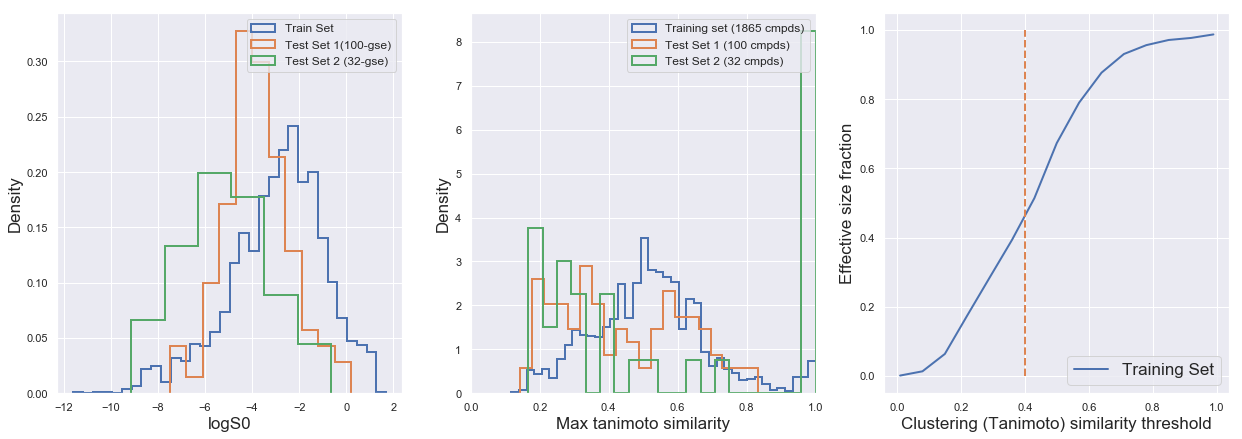

In [4]:
fig, axis = plt.subplots(1, 3, figsize=(21,7))

ax1 = axis[0]
ax2 = axis[1]
ax3 = axis[2]

ax2.set_xlim([0,1])

# Input files
training_set_file = '{}/../../data/training/solubility.uniq.no-in-100.smi'.format(CURRENT_PATH)
f_100_gse = '{}/../../data/test/test_100.with.gse.smi'.format(CURRENT_PATH)
f_32_gse = '{}/../../data/test/test_32.with.gse.smi'.format(CURRENT_PATH)
set_100_smiles_file = '{}/../../data/test/test_100.smi'.format(CURRENT_PATH)
set_32_smiles_file = '{}/../../data/test/test_32.smi'.format(CURRENT_PATH)

# Subplot 1
plot_data(training_set_file, ax1, 'Train Set')
plot_data(f_100_gse, ax1, 'Test Set 1(100-gse)')
plot_data(f_32_gse, ax1, 'Test Set 2 (32-gse)')
ax1.set_xlabel("logS0", fontsize=17)
ax1.set_ylabel("Density", fontsize=17)
ax1.legend(fontsize=12)


# Subplot 2
plot_sims(training_set_file, training_set_file, ax2, nbins=40, label='Training set (1865 cmpds)')
plot_sims(training_set_file, set_100_smiles_file, ax2, nbins=20, label='Test Set 1 (100 cmpds)')
plot_sims(training_set_file, set_32_smiles_file, ax2, nbins=20, label='Test Set 2 (32 cmpds)')
ax2.set_xlabel("Max tanimoto similarity", fontsize=17)
ax2.set_ylabel("Density", fontsize=17)
ax2.legend(fontsize=12)


# Subplot 3
plot_effective_size(training_set_file, ax3)
ax3.set_xlabel("Clustering (Tanimoto) similarity threshold", fontsize=17)
ax3.set_ylabel("Effective size fraction", fontsize=17)
ax3.legend(fontsize=17)

The distributions above hint to the reason why the models perform poorly on Test Set 1 and Test Set 2. As we can see (the first plot from the left), the compounds in the testing sets TS-1 and TS-2 are not drawn from the same distribution. The [mode](https://en.wikipedia.org/wiki/Mode_(statistics)) of $\rm logS_0$ for the training set is around $mode(\rm{log}S_0)\approx -2$, whereas it's about $mode(\rm{log}S_0)\approx -4$ for TS-1 and $mode(\rm{log}S_0)\approx -6$ for TS-2. These differences cannot be completely explained by the inacurracy of GSE, as the [RMSE](https://github.com/pgniewko/solubility/blob/master/data/raw/LA.2019.JCIM.xlsx) for this model is of the order of $1 ~\rm{log}~unit$. Thus, the fact that the physico-chemical space for the two test sets overlap only partially with the physico-chemical space of the training set, suggests the poor generalization of the models; especially in the Random Forest case. This is further backed up by the chemical similarity (middle plot). This plot provides the maximal Tanimoto similarity between the training set and the compounds from the training (excluding identity; blue line), Test 1 (orange line) and Test 2 (green line) sets. We can see that the similairy trends follow the $\rm logS_0$ trends - as the physico-chemical properties differ more from the traning sets, the similiary also drops. As a side note, the peak at similarity=1 for Test Set 2 comes from analogous compounds, that gave rise to the same ECFP4 fingerprints. 

Finally it's important to mention that the amount of the training data is rather small, at ~1900 datapoints. For such a small sample size, it's not surprising that the Deep Learning methods do not deliver expected performance, but rather, perform on par with the classical ML methods. However, the plot in the middle (and visual inspection of the training dataset) suggests that the training set contains many chemical analogs. Because of that, datapoints can be stongly correlated, and their contribution can be relatively lower than the datapoints from a distinct part of the chemical space. To check the span of the compounds in the training set, I clustered the compounds using the [Butina] algorithm at different similarity thresholds. The assumption is that compounds in a cluster contribute little to no novel chemical information, and therefore a single representative of the cluster suffices for the entire cluster of analogs. As we can see in the right-most figure, at the threshold $\approx 0.4$, the number of the original datapoints is reduced by abut 55% (compounds with the Tanimoto similarity $>0.4$ are usually considered analogs). Thus, the effective size of the training dataset is even lower, at about 850. In that perspective, it becomes more clear that a relatively simple `ESOL` model generalizes better because it is physics-based, has few fitting parameters, and has less capacity to overfit on the training dataset.

## Low-dimensional embeddings

In [5]:
smiles_list = []
labels = []
LOG_S0 = []

with open(training_set_file, 'r') as fin:
    for line in fin:
        pairs = line.rstrip().split(',')
        smiles_list.append(pairs[0])
        labels.append(0)
        LOG_S0.append(float(pairs[1]))

with open(set_100_smiles_file, 'r') as fin:
    for line in fin:
        compound = line.rstrip()
        smiles_list.append(compound)
        labels.append(1)

with open(set_32_smiles_file, 'r') as fin:
    for line in fin:
        compound = line.rstrip()
        smiles_list.append(compound)
        labels.append(2)
        
data = []
for compound in smiles_list:
    bits = np.array(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(compound), 3, nBits=1024))
    data.append(bits)

data = np.array(data)

data_cleaned = []
for i in range(data.shape[1]):
    std= np.std(data[:, i])
    if std != 0:
        data_cleaned.append(data[:, i])
data_cleaned = np.array(data_cleaned)
data_cleaned = data_cleaned.T

In [6]:
# Dimensionality reduction 
zscores = stats.zscore(data_cleaned, axis=0, ddof=1)
pca = PCA(n_components=20)
zscores_pca = pca.fit_transform(zscores)

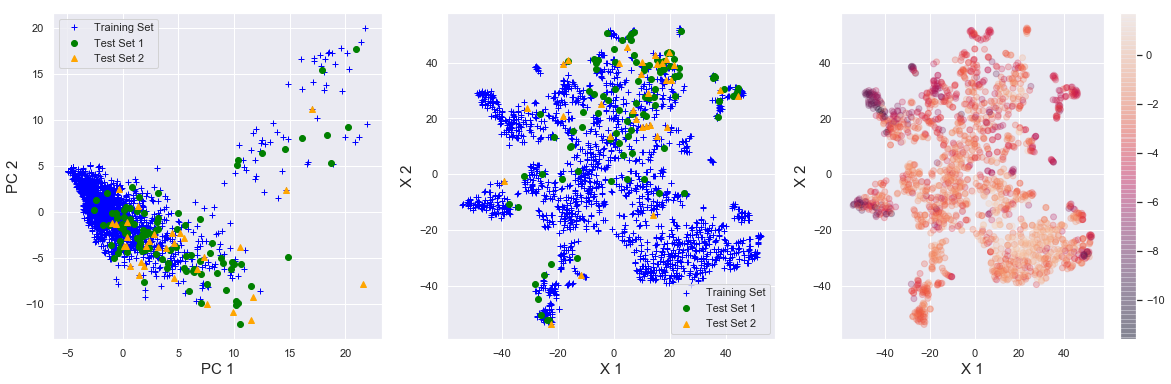

In [11]:
fig, axis = plt.subplots(1, 3, figsize=(20, 6))

ax1 = axis[0]
ax2 = axis[1]
ax3 = axis[2]

y = np.cumsum(pca.explained_variance_ratio_)
x = [i+1 for i in range(len(y))]

# Each class correspond to the molecular target
color_map = {0:'blue', 1:'green', 2:'orange'}
marker_map = {0:'+', 1:'o', 2:'^'}
labels_map = {0:'Training Set', 1:'Test Set 1', 2:'Test Set 2'}

for label, color in color_map.items():
    x = [zscores_pca[i, 0] for i in range(len(labels)) if labels[i] == label]
    y = [zscores_pca[i, 1] for i in range(len(labels)) if labels[i] == label]
    ax1.plot(x, y, marker_map[label], c=color, label=labels_map[label])
ax1.legend()
ax1.set_xlabel("PC 1", fontsize=15)
ax1.set_ylabel("PC 2", fontsize=15)

# Embed first 50 PCs. 
X_embedded = TSNE(n_components=2).fit_transform(zscores_pca[:, 0:10])

for label, color in color_map.items():
    x = [X_embedded[i, 0] for i in range(len(labels)) if labels[i] == label]
    y = [X_embedded[i, 1] for i in range(len(labels)) if labels[i] == label]
    ax2.plot(x, y, marker_map[label], c=color, label=labels_map[label])
ax2.legend()
ax2.set_xlabel("X 1", fontsize=15)
ax2.set_ylabel("X 2", fontsize=15)


min_s0 = min(LOG_S0)
max_s0 = max(LOG_S0)
LOG_S0_SCALED = LOG_S0
color = [s0 for s0 in LOG_S0_SCALED]

# Log_s0 in X1-X2 coordinate system
x = [X_embedded[i, 0] for i in range(len(labels)) if labels[i] == 0]
y = [X_embedded[i, 1] for i in range(len(labels)) if labels[i] == 0]

im = ax3.scatter(x, y, c=color, alpha=0.25, label=labels_map[0])
ax3.set_xlabel("X 1", fontsize=15)
ax3.set_ylabel("X 2", fontsize=15)
fig.colorbar(im, ax=ax3)

**(A)** 2D projection in the Principal Components space. PCA was performed with all the data-points, _i.e._ training and two test sets. **(B)** 2D t-SNE embedding done with 10 most imprtant PCs. **(C)** Same as (B) but only traning dataset is plotted and data-points are color coded accoring their $\rm log S_0$ values.

### "Solubility cliffs"

Water solubility prediction is challanging; Not only is there a limited amount of data, it can also be problematic because the solubility is measured when the dissolved compound is in equilibirum with its own solid phase. For example, depending on the form of [Diflunisal](https://www.drugbank.ca/drugs/DB00861), four different solubilities were [measured](https://github.com/pgniewko/solubility/blob/master/papers/HEL.2009.JCIM.pdf), and these values can differ by 2 orders of magnitreds (2 log units).

Another challange may arise when two structurally similar compounds have significantly different solubility values, $\rm logS_0$. The paragraph below analyzes these cases, called here "solubility cliffs".

In [8]:
TRAINING_DATA = '{}/../../data/training/solubility.uniq.no-in-100.smi'.format(CURRENT_PATH)

smiles = []
logS = []

with open(TRAINING_DATA, 'r') as fin:
    for line in fin:
        pairs = line.rstrip().split(',')
        smiles.append(pairs[0])
        logS.append(float(pairs[1]))

In [9]:
fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), 3, nBits=1024) for x in smiles]

In [10]:
fps_sim = []
loS0_delta = []
compounds_1 = []
compounds_2 = []
index = 1
for i in range(len(fps)):
    for j in range(len(fps)):
        if j <= i:
            continue
        sim = sim_ij = DataStructs.TanimotoSimilarity(fps[i], fps[j])
        fps_sim.append(sim)
        loS0_delta.append(abs(logS[i] - logS[j]))
        if sim > 0.7 and abs(logS[i] - logS[j]) > 2.0:
            compounds_1.append((smiles[i], logS[i], index, sim))
            compounds_2.append((smiles[j], logS[j], index))
            index += 1

#### Distribution of the compounds similaritues and differences in the training dataset.

Text(0, 0.5, '$logS_0$ differene')

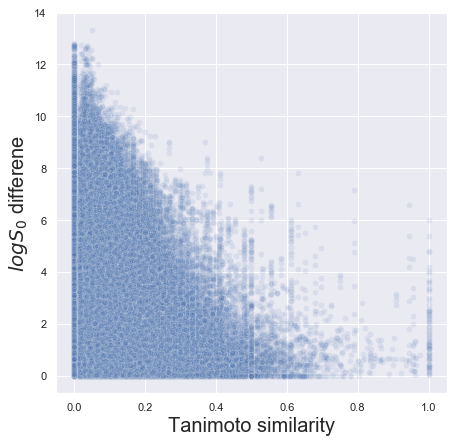

In [11]:
fig = plt.figure(figsize=(7, 7))
sns.scatterplot(fps_sim, loS0_delta, markers='.', alpha=0.1)
plt.xlabel('Tanimoto similarity', fontsize=20)
plt.ylabel('$logS_0$ differene', fontsize=20)

As we can see, there is some number of compounds that are very similar to each other (similarity > 0.7), but having $\Delta(log S_0) > 2$.

,Mol-1,Mol-2,Tanimoto,logS0-1,logS0-2,Delta
0,,,1.000000,-3.6300,-7.208,3.5780
1,,,0.789474,-3.6300,-1.240,2.3900
2,,,1.000000,-3.6300,-8.400,4.7700
3,,,1.000000,-3.6300,-6.350,2.7200
4,,,1.000000,-3.6300,-6.008,2.3780
5,,,0.944444,-4.7025,-1.810,2.8925
6,,,1.000000,-4.7025,-7.208,2.5055
7,,,0.789474,-4.7025,-1.240,3.4625
8,,,1.000000,-4.7025,-8.400,3.6975
9,,,1.000000,-4.7025,-2.390,2.3125

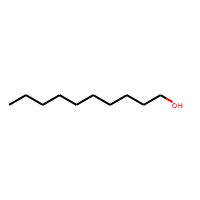
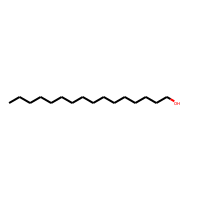
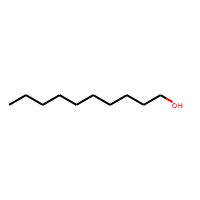
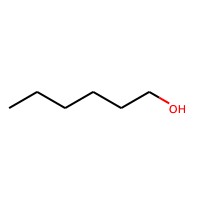
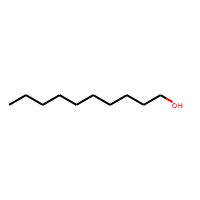
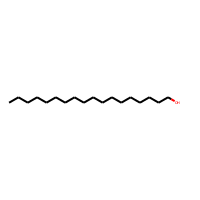
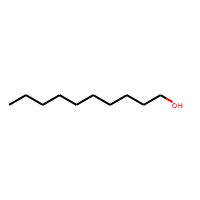
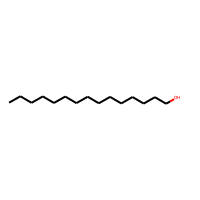
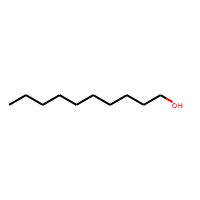
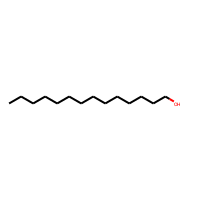
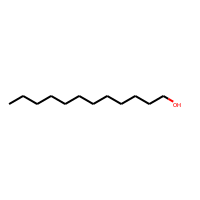
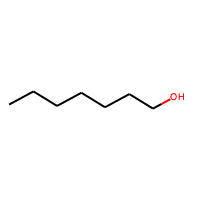
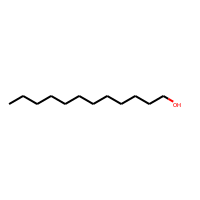
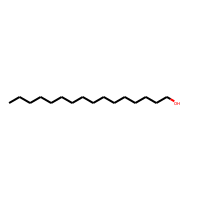
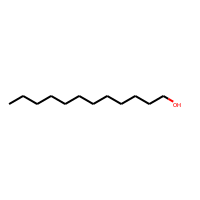
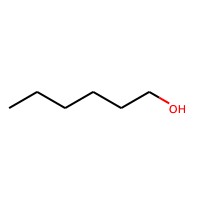
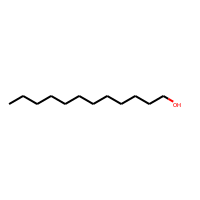
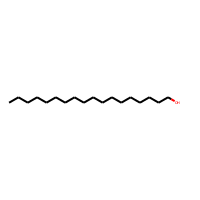
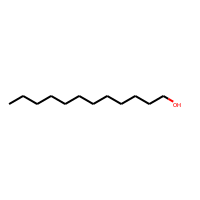
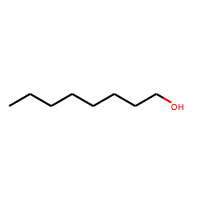

In [12]:
df_1 = pd.DataFrame(compounds_1, columns=['Smiles', 'logS0', 'index', 'sim'])
df_2 = pd.DataFrame(compounds_2, columns=['Smiles', 'logS0', 'index'])
PandasTools.AddMoleculeColumnToFrame(df_1)
PandasTools.AddMoleculeColumnToFrame(df_2)

df= df_1.merge(df_2, left_on='index', right_on='index')
df.columns = ['Smiles-1', 'logS0-1', 'index', 'Tanimoto', 'Mol-1', 'Smiles-2', 'logS0-2', 'Mol-2']
df = df.drop(['Smiles-1', 'Smiles-2','index'],axis=1)
df = df[['Mol-1', 'Mol-2', 'Tanimoto', 'logS0-1','logS0-2']]
df['Delta'] = abs(df['logS0-1'] - df['logS0-2'])
df.head(10)

The number of pairs with very similar structure and yet different solubility is 63. These pairs are mostly for symmetric and aromotic compounds or aliphatic acids and alcohols. In these cases we can see that a substitution of an additional $-CH_3$ group may lead to a significant change of the compound solubilty.